# Using QSVT for Matrix Inversion

This notebook uses the Quantum Singular Value Transformation (QSVT) algorithm to solve the problem of matrix inversion.
The demo is based on the [Grand unification of quantum algorithms](#grand) paper.

## Problem Encoding

We start by defining a specific problem. We can take a matrix that is not symmetric, in comparison to the HHL algorithm.

We encode $A$ in a larger unitary matrix. For simplicity, we just sample a random unitary U_a and take its first block as $A$.

In [1]:
import numpy as np
import scipy

# the size of the unitary which block encodes A
REG_SIZE = 3


def get_random_unitary(num_qubits, seed=4):
    np.random.seed(seed)
    X = np.random.rand(2**num_qubits, 2**num_qubits)
    U, s, V = np.linalg.svd(X)
    return U @ V.T


U_a = get_random_unitary(REG_SIZE)

A_dim = int(U_a.shape[0] / 2)
A = U_a[:A_dim, :A_dim]
print(A)

[[-0.05338002 -0.36103662 -0.54016489 -0.39026125]
 [-0.33304121  0.10648228  0.37346704 -0.33977916]
 [ 0.4167817  -0.75180519  0.17593867  0.20944773]
 [ 0.26891079 -0.05333795 -0.32668787 -0.33602829]]


Make sure the singular values for A are smaller than 1:

In [2]:
assert not (np.linalg.svd(A)[1] > 1).sum()

In [3]:
b = np.arange(A_dim)
b = b / np.linalg.norm(b)
print(b)

[0.         0.26726124 0.53452248 0.80178373]


Verify $U_{a}$ is indeed unitary

In [4]:
assert np.allclose(U_a @ U_a.T, np.eye(U_a.shape[0]), rtol=1e-5, atol=1e-6)

Calculate the condition number $\kappa=max(\frac{1}{\sigma_i})$:

In [5]:
kappa = max(1 / np.linalg.svd(A)[1])
print(kappa)

3.459862838470871


In [6]:
np.linalg.svd(A)[1]

array([0.99132079, 0.84978294, 0.52403662, 0.2890288 ])

## Now for the Quantum Part!

### Defining the QSVT Circuit for the Problem

We start with the general QSVT framework definition. It accepts a unitary that block-encodes a matrix together with projector-controlled-cnot functions, which identify the block in which the matrix is encoded.

It applies the `qsvt_step` multiple times, iterating over the rotation angles provided that encode the polynomial transformation.
Note that the last step is quite tricky and depends on the specific transformation we wish to perform. Here the code is suitable for the matrix-inversion case. In addition, we wrap the auxilliary qubit with $H$ gates.

In [7]:
from classiq import *
from classiq.qmod.symbolic import floor


@qfunc
def my_projector_controlled_phase(
    phase: CReal,
    proj_cnot: QCallable[QArray[QBit], QBit],
    state: QArray[QBit],
    aux: QBit,
) -> None:
    proj_cnot(state, aux)
    RZ(phase, aux)
    proj_cnot(state, aux)


@qfunc
def my_qsvt_step(
    phase1: CReal,
    phase2: CReal,
    proj_cnot_1: QCallable[QArray[QBit], QBit],
    proj_cnot_2: QCallable[QArray[QBit], QBit],
    u: QCallable[QArray[QBit]],
    state: QArray[QBit],
    aux: QBit,
):
    u(state)
    my_projector_controlled_phase(phase1, proj_cnot_2, state, aux)
    invert(lambda: u(state))
    my_projector_controlled_phase(phase2, proj_cnot_1, state, aux)


@qfunc
def my_qsvt(
    phase_seq: CArray[CReal],
    proj_cnot_1: QCallable[QArray[QBit], QBit],
    proj_cnot_2: QCallable[QArray[QBit], QBit],
    u: QCallable[QArray[QBit]],
    state: QArray[QBit],
    aux: QBit,
) -> None:
    H(aux)

    my_projector_controlled_phase(phase_seq[0], proj_cnot_1, state, aux)
    repeat(
        count=floor((phase_seq.len - 1) / 2),
        iteration=lambda index: my_qsvt_step(
            phase_seq[2 * index + 1],
            phase_seq[2 * index + 2],
            proj_cnot_1,
            proj_cnot_2,
            u,
            state,
            aux,
        ),
    )

    if_(
        condition=phase_seq.len % 2 == 1,
        then=lambda: IDENTITY(state),
        else_=lambda: (
            u(state),
            my_projector_controlled_phase(
                phase_seq[phase_seq.len - 1],
                proj_cnot_2,
                state,
                aux,
            ),
        ),
    )

    H(aux)

### Matrix Inversion Logic

We define the specific use case of the matrix inversion. In this case, both projectors are the same, and we expect the block-encoded matrix to apply on the states where the first qubit value is $|0\rangle$:

In [8]:
@qfunc
def my_qsvt_inversion(
    phase_seq: CArray[CReal],
    u: QCallable[QArray[QBit]],
    state: QArray[QBit],
    aux: Output[QBit],
) -> None:
    allocate(1, aux)

    def _projector_cnot(state: QArray[QBit], aux: QBit):
        X(state[state.len - 1])
        CX(state[state.len - 1], aux)
        X(state[state.len - 1])

    my_qsvt(
        phase_seq,
        lambda arg0, arg1: _projector_cnot(arg0, arg1),
        lambda arg0, arg1: _projector_cnot(arg0, arg1),
        u,
        state,
        aux,
    )

### Getting the Phase Sequence for the Inverse Function

Get the coefficient of the sign function directly, based on the ERFC approximation, using the `pyqsp` package:

In [9]:
# The following code assumes pyqsp version 0.1.6
# !pip install pyqsp==0.1.6
import pyqsp

pg = pyqsp.poly.PolyOneOverX()
pcoefs = pg.generate(epsilon=0.05, kappa=kappa)

b=50, j0=20
[PolyOneOverX] minimum [-4.54115308] is at [-0.15883407]: normalizing
[PolyOneOverX] bounding to 0.5
[pyqsp.PolyOneOverX] pcoefs=[ 0.00000000e+00  5.50501781e+00  0.00000000e+00 -1.34815163e+02
  0.00000000e+00  2.15191868e+03  0.00000000e+00 -2.50709632e+04
  0.00000000e+00  2.25502975e+05  0.00000000e+00 -1.61156021e+06
  0.00000000e+00  9.27860774e+06  0.00000000e+00 -4.33007019e+07
  0.00000000e+00  1.64161062e+08  0.00000000e+00 -5.05820849e+08
  0.00000000e+00  1.26571548e+09  0.00000000e+00 -2.56671992e+09
  0.00000000e+00  4.20178645e+09  0.00000000e+00 -5.51711201e+09
  0.00000000e+00  5.75258027e+09  0.00000000e+00 -4.69115938e+09
  0.00000000e+00  2.92363543e+09  0.00000000e+00 -1.34306985e+09
  0.00000000e+00  4.28212620e+08  0.00000000e+00 -8.45647522e+07
  0.00000000e+00  7.78663704e+06]


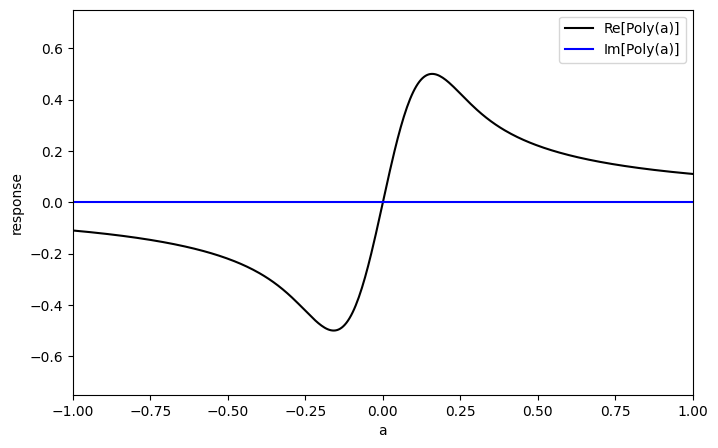

In [10]:
import numpy as np
from pyqsp.angle_sequence import Polynomial, QuantumSignalProcessingPhases

poly = Polynomial(pcoefs)

# choosing 'z' this basis since P(1)=1 and won't to avoid the QSP basis change. Anyway, we are not measuring directly this qubit.
ang_seq = QuantumSignalProcessingPhases(
    poly, signal_operator="Wx", method="laurent", measurement="x"
)
pyqsp.response.PlotQSPResponse(ang_seq, signal_operator="Wx", measurement="x")

### Adjusting Phase Conventions

The conventions by which the `pyqsp` package calculates the the phases are different from the phases we need for this QSVT circuit. The following block takes care of them.

As $R(a)=-i*e^{i\frac{\pi}{4}Z}W(a)e^{i\frac{\pi}{4}Z}$ and we have an odd number of rotations, we get an i phase for our polynomial, so we get $Im(P(a))$ instead of the real part. We receive the result in the $|1\rangle$ state in the ancilla, which can be fixed by adding a $\pi/2$ phase to the last or first rotation.

In [11]:
# change the R(x) to W(x), as the phases are in the W(x) conventions
phases = np.array(ang_seq)
phases[1:-1] = phases[1:-1] - np.pi / 2
phases[0] = phases[0] - np.pi / 4
phases[-1] = phases[-1] + (2 * (len(phases) - 1) - 1) * np.pi / 4

# verify conventions. minus is due to exp(-i*phi*z) in qsvt in comparison to qsp
phases = -2 * phases

### Using the Inversion Function to Solve a Linear System

The following block defines the `main` function. This is the entry point for the quantum algorithm, which brings all the previous parts together.

Specifically, we use the `prepare_amplitudes` function to load the $b$ vector into the quantum state. We then apply 'qsvt_inversion`. We use the dagger of the unitary $U$ that block-encodes $A$, because, using the SVD decomposition:
$$
\begin{align}
A &=W\Sigma V^\dagger\\
A^\dagger &=V^\dagger \Sigma W\\
A^{-1} &= V^\dagger \Sigma^{-1}W\\
\end{align}
$$

In [12]:
@qfunc
def main(
    state: Output[QNum],
    block: Output[QBit],
    aux: Output[QBit],
) -> None:
    full_state = QArray("full_state")

    prepare_amplitudes(b.tolist(), 0, state)

    allocate(1, block)
    bind([state, block], full_state)

    my_qsvt_inversion(
        phase_seq=list(phases),
        u=lambda arg0: unitary(
            # Here we can just use the transpose of A as is it real valued
            elements=U_a.T.tolist(),
            target=arg0,
        ),
        state=full_state,
        aux=aux,
    )

    bind(full_state, [state, block])

## Synthesizing and Executing the Circuit Using a State Vector Simulator

We want to get $x=A^{-1}b$:

In [13]:
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)

# convert the functions to a qmod model
qmod = create_model(main)

# we will want to execute this qmod on a state-vector simulator:
execution_preferences = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)
qmod = set_execution_preferences(qmod, execution_preferences)

write_qmod(qmod, name="qsvt_matrix_inversion", decimal_precision=15)

We synthesize the model into a quantum program:

In [14]:
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/2utzcmuFI9rw2mypQUToHITinbX?login=True&version=0.73.0
https://platform.classiq.io/circuit/2utzcmuFI9rw2mypQUToHITinbX?login=True&version=0.73.0


We execute it on the simulator:

In [15]:
result = execute(qprog).result_value()

## Postprocessing

We are interested in the projection of the state vector on the states where both the auxilliary qubit and the block qubit are $|0\rangle$:

In [16]:
def parse_results(result):
    parsed_state_vector = result.parsed_state_vector

    d = {
        int(parsed_state["state"]): parsed_state.amplitude
        for parsed_state in parsed_state_vector
        if parsed_state["aux"] == parsed_state["block"] == 0.0
    }

    values = np.array([d[i] for i in range(len(d))])
    global_phase = np.angle(values)[0]
    values = np.real(values / np.exp(1j * global_phase))
    normalization = np.linalg.norm(
        [
            parsed_state.amplitude
            for parsed_state in parsed_state_vector
            if parsed_state["block"] == 0.0
        ]
    )
    computed_x = values / normalization
    return computed_x

In [17]:
parsed_state_vector = result.parsed_state_vector

d = {
    parsed_state["state"]: parsed_state.amplitude
    for parsed_state in parsed_state_vector
    if parsed_state["aux"] == parsed_state["block"] == 0.0
}

In [18]:
computed_x = parse_results(result)
print(computed_x)

[ 0.30898639  0.02161554  0.14214866 -0.26100823]


Let's compare it with the expected solution:

In [19]:
expected_x = 1 / (2 * kappa) * (np.linalg.inv(A) @ b)
print(expected_x)

assert np.allclose(computed_x, expected_x, rtol=0.1)

[ 0.29134204  0.02176207  0.13386997 -0.24527315]


## References

<a id='grand'>[1]</a>: [Martyn JM, Rossi ZM, Tan AK, Chuang IL. Grand unification of quantum algorithms. PRX Quantum. 2021 Dec 3;2(4):040203.](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040203)
